In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#mpl.rcParams["savefig.dpi"]=140
#mpl.rcParams["figure.dpi" ]=140

## Coloring based on nearest hybercube

Define a planar cut through an ND lattice, and color pixels on this plane according to nearest cube.

Note: To simplify some things later:
- Ensure that all angles are positive
- Ensure that the last angle is π (vertical)

In [183]:
from scipy.spatial.distance import squareform, pdist
from pylab import *
from numpy import * 
from scipy.linalg import null_space
from itertools import product, combinations
from scipy.spatial import Delaunay, delaunay_plot_2d


Ndepth = 5
N = 6                      # Dimension of crystal
D = int32(concatenate([eye(N),-eye(N)])) 
S = zeros((N,N))
S[ -1,0 ] = -1
S[:-1,1:] = eye(N-1)
θ = linspace(0,pi,N+1)[1:] # Arrange basis vectors evenly on [0,π)
A = array([cos(θ),sin(θ)]) # Convert from complex notation

def cached_crystal_checker(check):
    # Cache results to save time (memoization)
    cache = {}
    def f(q):
        # Convert test point to immutable tuple for cache key
        k = tuple(int32(q)) 
        if not k in cache:
            # Recompute intersection test if not in cache
            # Use symmetry: reduce tests to points in 1st sector
            h = angle([1,1j]@A@q)
            cache[k]=check(q) if 0<=h<=(pi/N*1.1) else f(S@q)
        return cache[k]
    f.__cache__ = cache
    return f



C = null_space(A).T
O = array([*product(*([0,1],)*N)])-0.5
F = array([*product(*([0,1],)*2)])
i = [0]+[*2**arange(N-2)]
G = array([*product(*([0,1],)*(N-2))])[i,:]
I = [*combinations(range(N),2)]
subfacets = []
for ij in I:
    # For every pair of directions, and for every 2-cube
    # in each pair of directions... Generate all possible
    # N-2-cube sub-facets.
    v0 = F@eye(N)[ij,:]
    v1 = G@eye(N)[[*{*range(N)}-{*ij}]]
    subfacets.extend(v0[:,None,:]+v1[None,:,:])
vxid = int32(subfacets)@2**arange(N,dtype='i')

# Chec if a sub-facet contains the origin
def subfacet_contains(v):
    p0 = v[0]
    vk = v[1:,:]-p0
    q  = -np.linalg.solve(vk@vk.T,vk@p0)
    return all(q>=0) and all(q<=1)

# Check if N-2 projection of N-cube contains the origin
# (thereby checking for plane-cube intersection)
@cached_crystal_checker
def check_g2(q):
    # Generate list of all N-2 dimensional sub-facets
    # of unit N-cube centered at q
    p  = (q+O).T
    sf = (C@p)[:,vxid].transpose(1,2,0)
    for v in sf:
        if subfacet_contains(v): return True
    return False

Q,allQ = {(0,)*N},set() 
for i in range(Ndepth):
    Q = {tuple(q) for p in Q for q in D+p if check_g2(q)}-allQ
    allQ |= Q

p = array(list(allQ)).T
p.shape

xy = pinv(A).T@p
dd = Delaunay(xy.T)


c2p = lambda z:array([real(z),imag(z)])

0.33333333333333337 0.33333333333333337 0.5773502691896258
0.33333333333333326 0.33333333333333326 0.33333333333333337
0.3333333333333333 0.33333333333333337 0.17254603006834726
0.3333333333333335 0.33333333333333337 0.3333333333333334
0.3333333333333332 0.33333333333333337 0.5773502691896257


(-1.7350852961085887,
 1.7350852961085887,
 -1.7350852961085887,
 1.7350852961085887)

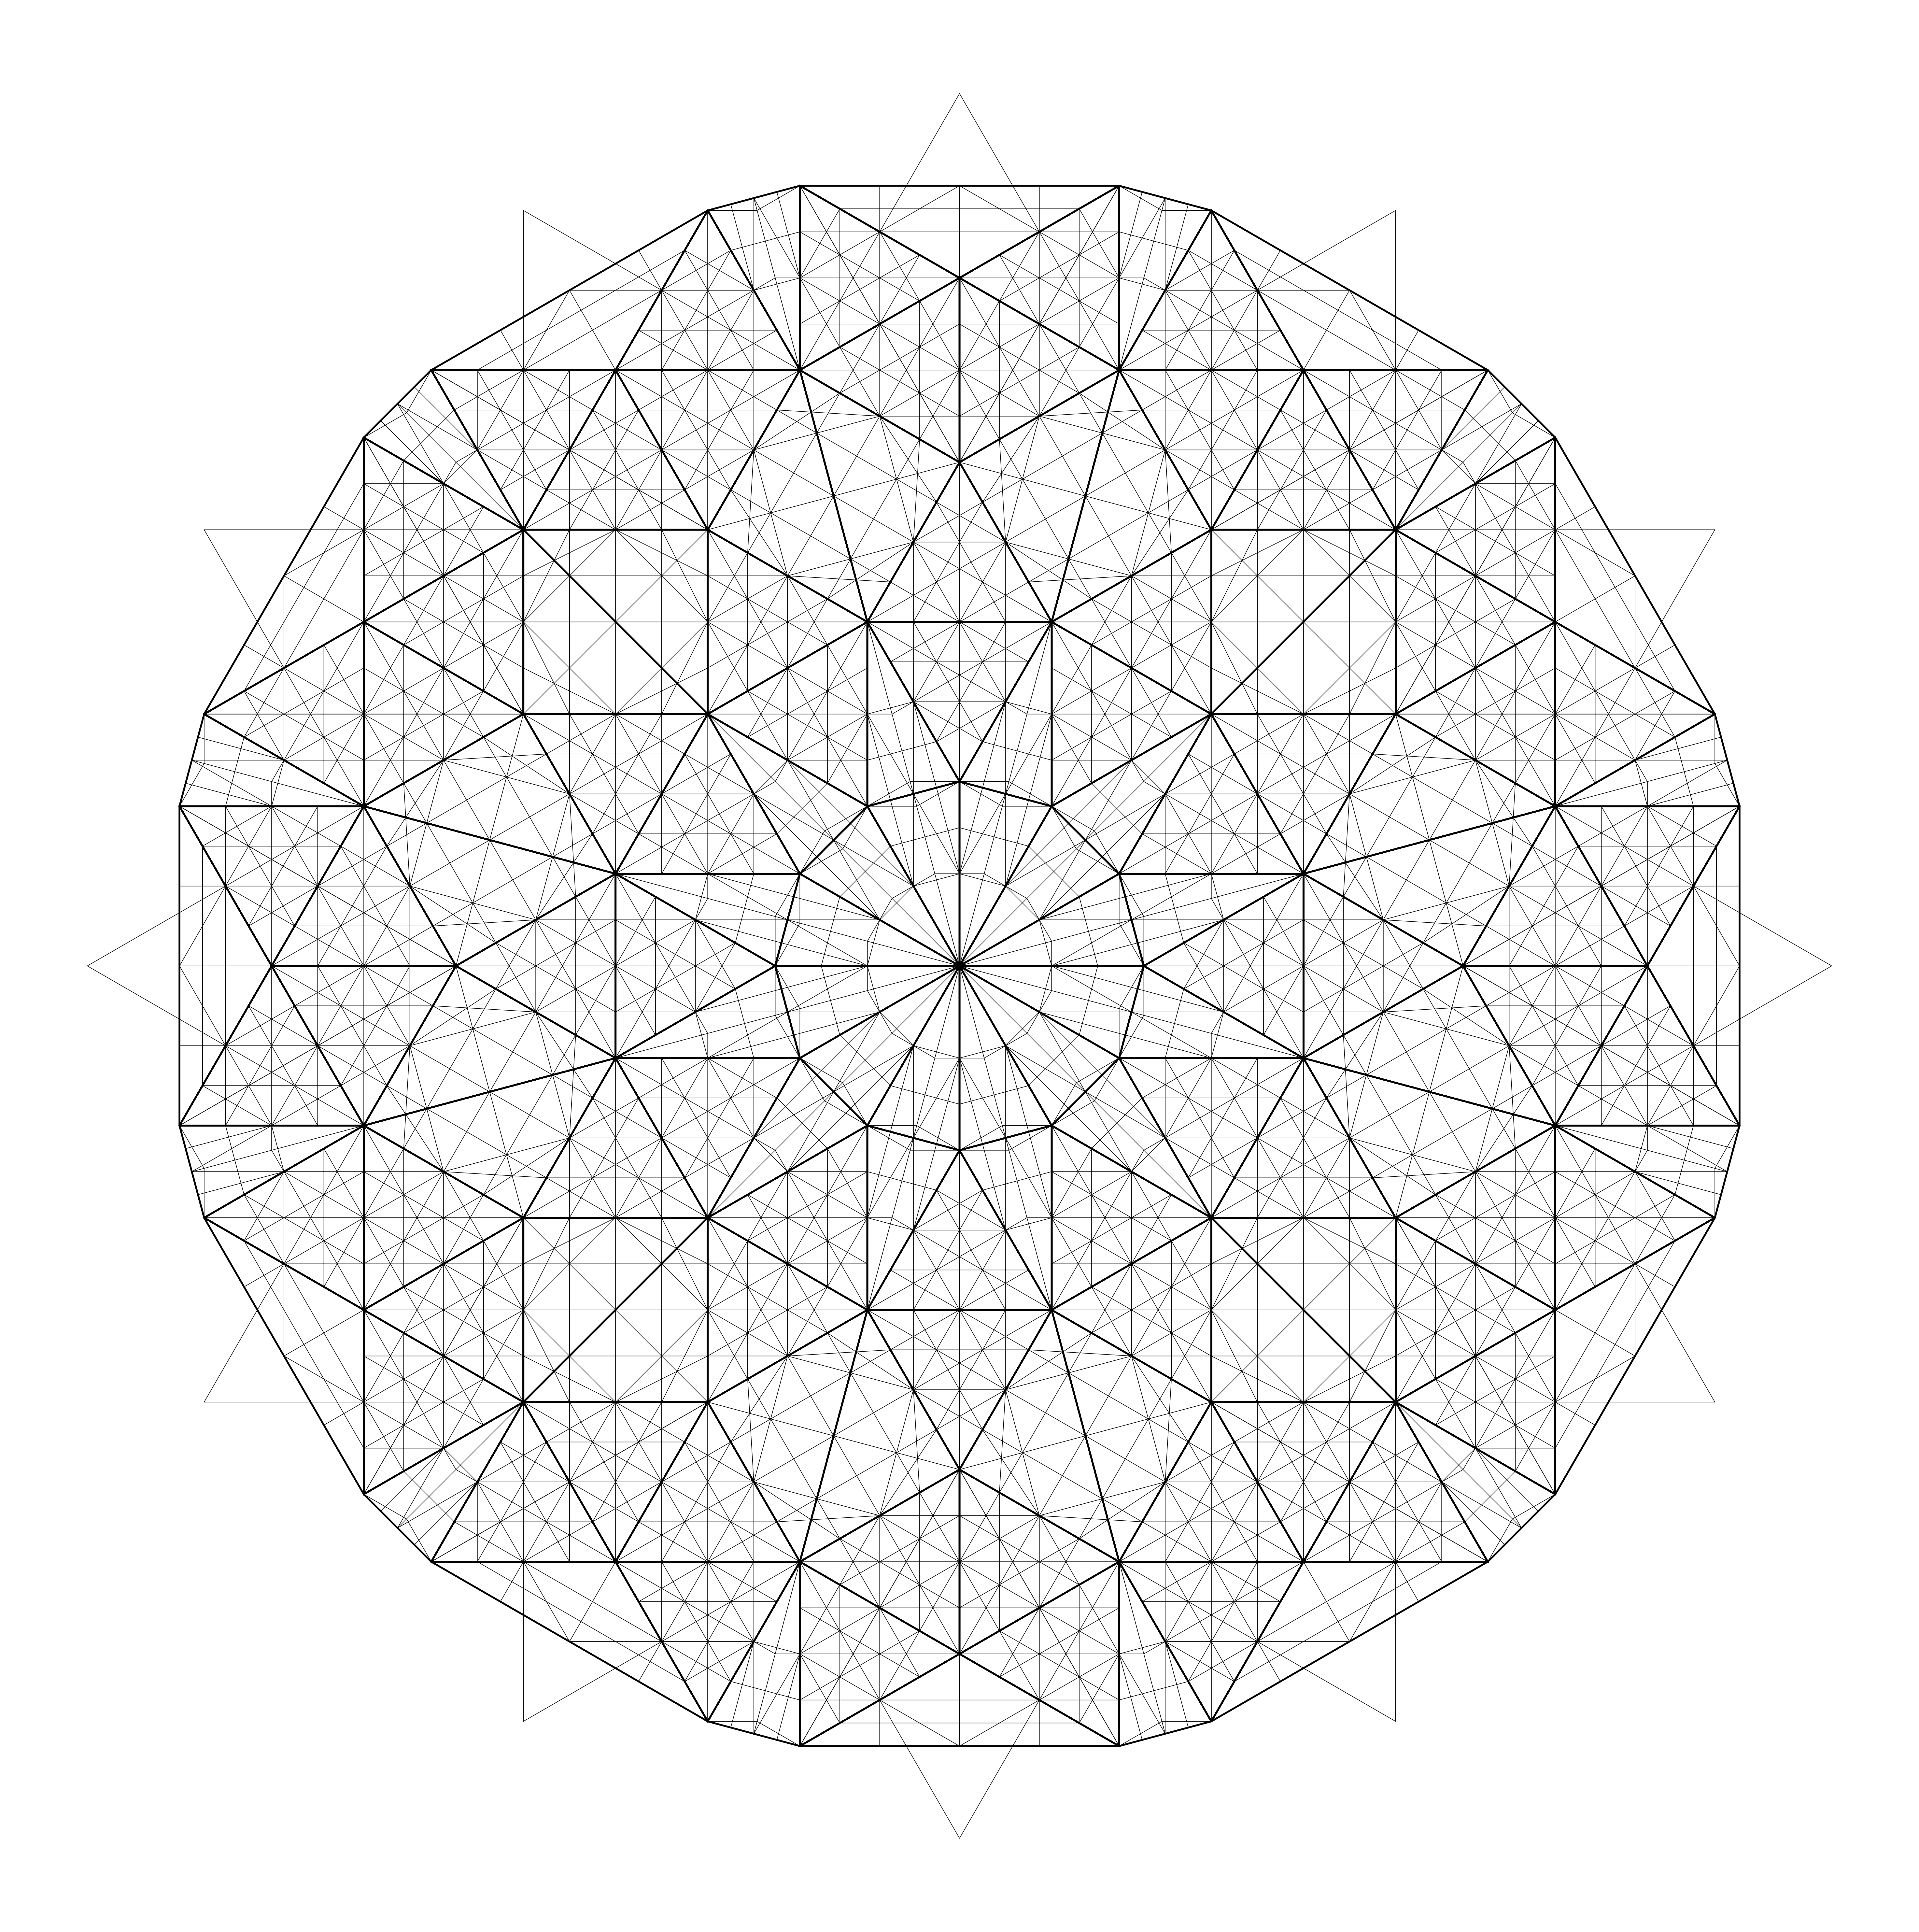

In [207]:

z = dd.points@[1,1j]
figure(figsize=(30,30),dpi=200)

    

    
all_lines = [[],[],[],[],[]]
for i,(a,b,c) in enumerate(z[dd.simplices]):
    d1 = abs(a-b)
    d2 = abs(b-c)
    d3 = abs(c-a)
    if not abs(d1-d2)<1e-4:
        d1,d2,d3 = d2,d3,d1
        a,b,c = b,c,a
    if not abs(d1-d2)<1e-4:
        d1,d2,d3 = d2,d3,d1
        a,b,c = b,c,a
    if not abs(d1-d2)<1e-4:
        continue # edge piece
        
    # Main triangular outline
    all_lines[4].extend([a,b,c,a,NaN])
    
    if abs(d3/d1-sqrt(2))<1e-4:
        # squares are a special case
        p1 = (c+a)/2
        all_lines[1]+=[b,p1,NaN] # isosceles bisector
        p2 = (a+b)/2
        p3 = (b+c)/2
        all_lines[3]+=[p2,p1,NaN] # Inner triangle
        all_lines[3]+=[p3,p1,NaN] # (between edge midpoints)
        all_lines[3]+=[p2,p3,NaN]
        p4 = (a+p1)/2
        p5 = (c+p1)/2
        all_lines[1]+=[p2,p4,NaN] # adjacent descender (parallel to isosceles bisector)
        all_lines[1]+=[p3,p5,NaN] # adjacent descender (parallel to isosceles bisector)
        
        # Conveyors
        ba = (b+a)/2
        bc = (b+c)/2
        ac = (a+c)/2
        all_lines[0]+=[ba,(b+bc)/2,NaN]
        all_lines[0]+=[bc,(b+ba)/2,NaN]
        all_lines[0]+=[ba,a-(b-c)/4,NaN] # oblique conveyors punch through
        all_lines[0]+=[bc,c-(b-a)/4,NaN]
        
        all_lines[0]+=[(b*3+a)/4,c+(a-b)/4,NaN]
        all_lines[0]+=[(b*3+c)/4,a+(c-b)/4,NaN]
        
    elif not (abs(d1-d2)/d1<1e-4 and abs(d1-d3)/d1<1e-4):
        p1 = (c+a)/2
        all_lines[0]+=[b,p1,NaN] # isosceles bisector
        p2 = (a+b)/2
        p3 = (b+c)/2
        all_lines[3]+=[p2,p1,NaN] # Inner triangle
        all_lines[3]+=[p3,p1,NaN] # (between edge midpoints)
        all_lines[3]+=[p2,p3,NaN]
        p4 = (a+p1)/2
        p5 = (c+p1)/2
        all_lines[0]+=[p2,p4,NaN] # adjacent descender (parallel to isosceles bisector)
        all_lines[0]+=[p3,p5,NaN] # adjacent descender (parallel to isosceles bisector)
        x = abs(p3-b)
        θ = angle((p1-b)/(c-b))
        u = x/cos(θ)
        v = (p1 - b)/abs(p1-b)
        g = b + u * v
        all_lines[1]+=[g,p3,NaN] # direct extendor 1
        v = (g-p3)/abs(g-p3)
        y = abs(p1-c)
        w = y/cos(θ)
        h = a - w * v
        all_lines[2]+=[a,h,NaN] # oblique extendor 1
        x = abs(p2-b)
        θ = angle((p1-b)/(c-b))
        u = x/cos(θ)
        v = (p1 - b)/abs(p1-b)
        g = b + u * v
        all_lines[1]+=[g,p2,NaN] # direct extendor 2
        v = (g-p2)/abs(g-p2)
        h = c - w * v
        all_lines[2]+=[c,h,NaN] # oblique extendor 2
        
        # bridge
        all_lines[3] += [(a*3+b)/4,(c*3+b)/4,NaN]
        
    else:
        # Triangles are a special case
        ab = (b+a)/2
        bc = (b+c)/2
        ca = (a+c)/2
        all_lines[0]+=[ab,c,NaN]
        all_lines[0]+=[bc,a,NaN]
        all_lines[0]+=[ca,b,NaN]
        all_lines[3]+=[ab,bc,ca,ab,NaN] # Inner triangle
        # bridges
        all_lines[3] += [ca,(a*3+b)/4,(c*3+b)/4,ca,NaN]
        all_lines[3] += [ab,(b*3+c)/4,(a*3+c)/4,ab,NaN]
        all_lines[3] += [bc,(c*3+a)/4,(b*3+a)/4,bc,NaN]
        
        
plot(*c2p(array(all_lines[0])),color='k',lw=0.6)
plot(*c2p(array(all_lines[1])),color='k',lw=0.6)
plot(*c2p(array(all_lines[2])),color='k',lw=0.6)
plot(*c2p(array(all_lines[3])),color='k',lw=0.6)
plot(*c2p(array(all_lines[4])),color='k',lw=2)
#plot(*c2p(array(all_lines[0]+all_lines[1]+all_lines[2]+all_lines[3]+all_lines[4])),color='k',lw=0.6)

tight_layout()
axis("equal")
axis("off")

#savefig('test_%d.png'%N)
#savefig('test_%d.svg'%N)